# Development - Pasiphae survey: sky field grid

In [69]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from textwrap import dedent

<div class="alert alert-block alert-warning">
<b>TODO:</b> Re-organize notebook structure: 1. Brief outline of gridding approaches. 2. Visualization functions. 3. Dec-circle grid. 4. Grand-circle grid. 5. Comparison. 6. Pasiphae grid (before I am using coarse test grids, now move to actual FoV). 6.1 North 6.2 South.
    
(Maybe comparision should come after pasiphae grid.)
</div>

## Setup

### Visualization functions

A *field* is rectangular has a center point and a width given by the field of view (FoV). For the visualization we calculate the coordinates of the four corner points. In different projections four points may not be enough to represent the shape of the field adequately, but as the simplest approximatio it will suffice.

We start in cartesian coordinates. We define the position of the four corner points. Then we rotate around the y-axis to move to the targeted declination. Then we rotate around the z-axis to rotate to the targeted right ascension (RA). Finally, we transform to spherical coordinates, i.e. RA, dec.

**First**, field corner points: We initiate the field at center point $(1, 0, 0)$. We define the corner points in the $x=1$-plane. For a FoV angle `fov` we need to move from the center point by $\pm\tan(\mathrm{fov}/2)$ in the y- and z-plane to reach the corner points. Note we are not on the unit-sphere. Projection onto the unit-sphere will be done later, simply by ignoring the radius.

In [70]:
def field_corners_init(fov):
    """Create field corner points in cartesian coordinates."""
    
    diff = np.tan(fov / 2.)
    x = np.ones(5)
    y = np.array([-diff, diff, diff, -diff, -diff])
    z = np.array([-diff, -diff, diff, diff, -diff])
    
    return x, y, z

**Second**, we define the tranformation from cartesian to spherical coordinates:

In [71]:
def cart_to_sphere(x, y, z):
    """Transform cartesian to spherical coordinates."""
    
    r = np.sqrt(x**2 + y**2 + z**2)
    za = np.arccos(z / r)
    dec = np.pi / 2. - za
    ra = np.arctan2(y, x)
    
    return ra, dec, r

For a demonstration we use a large FoV:

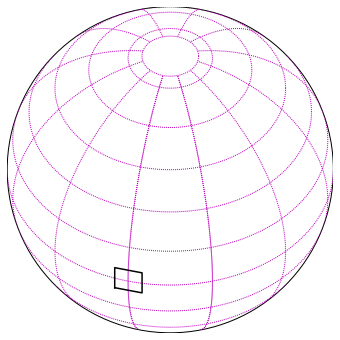

In [72]:
fov = 10. # deg
fov = np.radians(fov) # radian

x, y, z = field_corners_init(fov)
ra, dec, r = cart_to_sphere(x, y, z)

fig = plt.figure(figsize=(6, 6))
m = Basemap(projection='ortho',lon_0=15,lat_0=45,resolution='l')
m.drawparallels(np.arange(-90.,120.,15.),color='m',alpha=0.5)
m.drawmeridians(np.arange(0.,420.,30.),color='m',alpha=0.5)
m.plot(np.degrees(ra), np.degrees(dec), color='k', latlon=True);

Check separation between corner points:

In [73]:
coord = SkyCoord(ra, dec, unit='rad')

for i in range(4):
    print(coord[i].separation(coord[i+1]))

9d57m43.6996s
9d57m43.6996s
9d57m43.6996s
9d57m43.6996s


We note that the pairs of non-diagonal corner points are all separated by the same angle as intended, but by a smaller angle than the FoV. The reason is the projection from a sphere to a rectangle. The center cross has exactly the correct separation, demonstrated below for the central line along the declination, i.e. z-axis:

In [74]:
diff = np.tan(fov / 2.)
x = np.ones(2)
y = np.zeros(2)
z = np.array([-diff, diff])
ra, dec, r = cart_to_sphere(x, y, z)
coord = SkyCoord(ra, dec, unit='rad')
coord[0].separation(coord[1])

<Angle 10. deg>

Even though in linear coordinates every pair of opposite points on the rectangle has the same separation, in the projection of the sphere this is not the case. The separation decreases the further we go away from the central cross. Accordingly, the effect will be smaller for a smaller FoV than use here for demonstration purposes.

**Third**, we implement the rotation matrices.

Rotation around the x-axis for the case that the CCD is slightly tilted:

In [75]:
def rot_tilt(x, y, z, tilt):
    """Rotate around x-axis by tilt angle."""
    
    x_rot = x 
    y_rot = y * np.cos(tilt) - z * np.sin(tilt)
    z_rot = y * np.sin(tilt) + z * np.cos(tilt)
    
    return x_rot, y_rot, z_rot

Rotation around the y-axis to reach the target declination:

In [76]:
def rot_dec(x, y, z, dec):
    """Rotate around y-axis by declination angle."""
    
    dec = -dec
    x_rot = x * np.cos(dec) + z * np.sin(dec)
    y_rot = y
    z_rot = -x * np.sin(dec) + z * np.cos(dec)
    
    return x_rot, y_rot, z_rot

Rotation around the z-axis to reach the targeted RA:

In [77]:
def rot_ra(x, y, z, ra):
    """Rotate around z-axis by right ascension angle."""
    
    x_rot = x * np.cos(ra) - y * np.sin(ra)
    y_rot = x * np.sin(ra) + y * np.cos(ra)
    z_rot = z
    
    return x_rot, y_rot, z_rot

Check that everything works as intended:

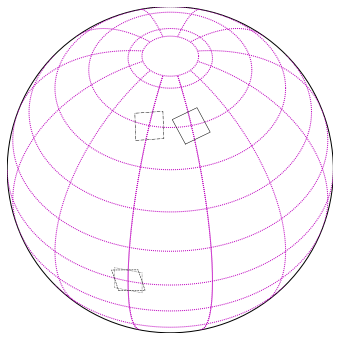

In [78]:
fov = 10. # deg
dec = 60. # deg
ra = 30. # deg
tilt = 15. # deg

fov = np.radians(fov) # radian
dec = np.radians(dec) # radian
ra = np.radians(ra) # radian
tilt = np.radians(tilt) # radian

x0, y0, z0 = field_corners_init(fov)
x1, y1, z1 = rot_tilt(x0, y0, z0, tilt)
x2, y2, z2 = rot_dec(x1, y1, z1, dec)
x3, y3, z3 = rot_ra(x2, y2, z2, ra)

fig = plt.figure(figsize=(6, 6))
m = Basemap(projection='ortho',lon_0=15,lat_0=45,resolution='l')
m.drawparallels(np.arange(-90.,120.,15.),color='m',alpha=0.5)
m.drawmeridians(np.arange(0.,420.,30.),color='m',alpha=0.5)

lines = [':', '--', '-.', '-']
for i in range(4):
    x, y, z = eval(f'x{i}, y{i}, z{i}')
    ra, dec, __ = cart_to_sphere(x, y, z)
    m.plot(np.degrees(ra), np.degrees(dec), color='k', linestyle=lines[i], linewidth=0.5, latlon=True);

Combine all in one function:

In [79]:
def field_corners(fov, ra=0., dec=0., tilt=0.):
    """Create field corner points at specified field center coordinates."""
    
    x, y, z = field_corners_init(fov)
    x, y, z = rot_tilt(x, y, z, tilt)
    x, y, z = rot_dec(x, y, z, dec)
    x, y, z = rot_ra(x, y, z, ra)
    ra, dec, __ = cart_to_sphere(x, y, z)
    
    return ra, dec

### Split circle in fields

We start with splitting the equator into $N = \mathrm{ceil}\left(\frac{2 \pi}{\mathrm{fov}}\right)$ fields:

In [80]:
fov = 10. # deg

fov = np.radians(fov) # radians
n = int(np.ceil(2 * np.pi / fov))
print(f'Number of fields: {n}')

Number of fields: 36


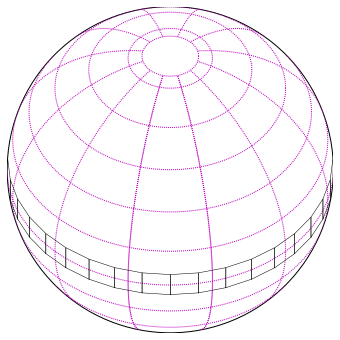

In [81]:
ras = np.arange(0., 2.*np.pi, fov)

fig = plt.figure(figsize=(6, 6))
m = Basemap(projection='ortho',lon_0=15,lat_0=45,resolution='l')
m.drawparallels(np.arange(-90.,120.,15.),color='m',alpha=0.5)
m.drawmeridians(np.arange(0.,420.,30.),color='m',alpha=0.5)

for ra in ras:
    ra, dec = field_corners(fov, ra=ra, dec=0., tilt=0.)
    m.plot(np.degrees(ra), np.degrees(dec), color='k', linestyle='-', linewidth=0.5, latlon=True);

Next we allow for an overlap between neighboring fields. If the overlap leads to an integer number of fields we use that number of fields. If the overlap does not result in an interger number, we use the next highest integer and increase the overlap accordingly. This way we equally distribute the overlap over all fields and do not end up with a much larger overlap between the pair of the first and last field around the equator. We split the equator into $N = \mathrm{ceil}\left(\frac{2 \pi}{\mathrm{fov} - \mathrm{overlap}}\right)$ fields:

Number of fields: 47
Overlap used: 2.34 deg


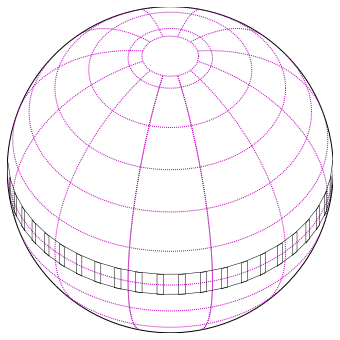

In [82]:
fov = 10. # deg
overlap = 2.2 # deg

fov = np.radians(fov) # radians
overlap = np.radians(overlap) # radians

n = int(np.ceil(2 * np.pi / (fov - overlap)))
print(f'Number of fields: {n}')

ras = np.linspace(0., 2.*np.pi, n+1)[:-1]
overlap_used = fov - (ras[1] - ras[0])
print('Overlap used: {0:.2f} deg'.format(np.degrees(overlap_used)))

fig = plt.figure(figsize=(6, 6))
m = Basemap(projection='ortho',lon_0=15,lat_0=45,resolution='l')
m.drawparallels(np.arange(-90.,120.,15.),color='m',alpha=0.5)
m.drawmeridians(np.arange(0.,420.,30.),color='m',alpha=0.5)

for ra in ras:
    ra, dec = field_corners(fov, ra=ra, dec=0., tilt=0.)
    m.plot(np.degrees(ra), np.degrees(dec), color='k', linestyle='-', linewidth=0.5, latlon=True);

Above we have split the equator into fields. At the equator the circumfence is $c = 2 \pi r$ with radius $r = 1$. At any declination $\delta$ the radius is $r = \cos \delta$. Accordingly, we split the circle at declination $\delta$ into $N = \mathrm{ceil}\left(\frac{2 \pi}{\mathrm{fov} - \mathrm{overlap}} \cos \delta\right)$ fields:

Number of fields: 40


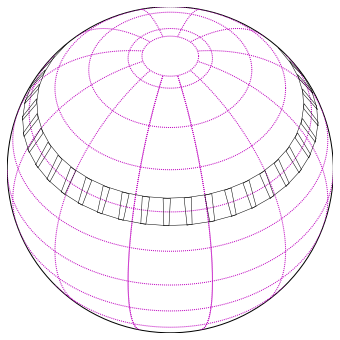

In [83]:
fov = 10. # deg
overlap = 2.2 # deg
dec = 30. # deg

fov = np.radians(fov) # radians
overlap = np.radians(overlap) # radians
dec = np.radians(dec) # radians

n = int(np.ceil(2 * np.pi / (fov - overlap)) * np.cos(dec))
print(f'Number of fields: {n}')

ras = np.linspace(0., 2.*np.pi, n+1)[:-1]

fig = plt.figure(figsize=(6, 6))
m = Basemap(projection='ortho',lon_0=15,lat_0=45,resolution='l')
m.drawparallels(np.arange(-90.,120.,15.),color='m',alpha=0.5)
m.drawmeridians(np.arange(0.,420.,30.),color='m',alpha=0.5)

for ra in ras:
    corners_ra, corners_dec = field_corners(fov, ra=ra, dec=dec, tilt=0.)
    m.plot(np.degrees(corners_ra), np.degrees(corners_dec), color='k', linestyle='-', linewidth=0.5, latlon=True);

Number of fields: 23


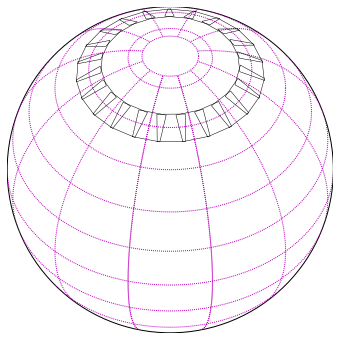

In [84]:
fov = 10. # deg
overlap = 2.2 # deg
dec = 60. # deg

fov = np.radians(fov) # radians
overlap = np.radians(overlap) # radians
dec = np.radians(dec) # radians

n = int(np.ceil(2 * np.pi / (fov - overlap)) * np.cos(dec))
print(f'Number of fields: {n}')

ras = np.linspace(0., 2.*np.pi, n+1)[:-1]

fig = plt.figure(figsize=(6, 6))
m = Basemap(projection='ortho',lon_0=15,lat_0=45,resolution='l')
m.drawparallels(np.arange(-90.,120.,15.),color='m',alpha=0.5)
m.drawmeridians(np.arange(0.,420.,30.),color='m',alpha=0.5)

for ra in ras:
    corners_ra, corners_dec = field_corners(fov, ra=ra, dec=dec, tilt=0.)
    m.plot(np.degrees(corners_ra), np.degrees(corners_dec), color='k', linestyle='-', linewidth=0.5, latlon=True);

Number of fields: 8


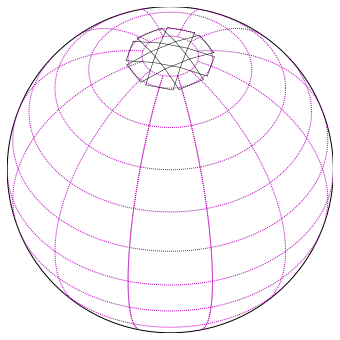

In [85]:
fov = 10. # deg
overlap = 2.2 # deg
dec = 80. # deg

fov = np.radians(fov) # radians
overlap = np.radians(overlap) # radians
dec = np.radians(dec) # radians

n = int(np.ceil(2 * np.pi / (fov - overlap)) * np.cos(dec))
print(f'Number of fields: {n}')

ras = np.linspace(0., 2.*np.pi, n+1)[:-1]

fig = plt.figure(figsize=(6, 6))
m = Basemap(projection='ortho',lon_0=15,lat_0=45,resolution='l')
m.drawparallels(np.arange(-90.,120.,15.),color='m',alpha=0.5)
m.drawmeridians(np.arange(0.,420.,30.),color='m',alpha=0.5)

for ra in ras:
    corners_ra, corners_dec = field_corners(fov, ra=ra, dec=dec, tilt=0.)
    m.plot(np.degrees(corners_ra), np.degrees(corners_dec), color='k', linestyle='-', linewidth=0.5, latlon=True);

<div class="alert alert-block alert-danger">
This scheme only works (a) when an overlap is defined, otherwise there will be a gap between the lower corners of adjacent fields, and (b) only up to a certain declination, which depends on the FoV and the overlap. Two changes/additions are needed: (1) Ensure no gaps! (2) It would be very useful to calculate the amount of actual overlap, which will differ from the case at the equator.
</div>

We implement the above in a generator function. Note that we add the special case of $\delta = \pm 90.$, which would not result in a field with the above code:

In [86]:
def field_centers_along_dec(fov, overlap=0., dec=0., verbose=0):
    """Iterator that yield the corner coordinates for each field along a circle at a given declination."""
    
    if np.isclose(np.absolute(dec), np.pi/2.):
        n = 1
        ras = [0]
    
    else:
        n = int(np.ceil(2 * np.pi / (fov - overlap)) * np.cos(dec))
        ras = np.linspace(0., 2.*np.pi, n+1)[:-1]
    
    if verbose > 0:
        print(f'Dec: {np.degrees(dec):+6.2f} deg. Number of fields: {n:4d}')
    
    for ra in ras:
        yield field_corners(fov, ra=ra, dec=dec, tilt=0.)

### Split sky in fields

Number of declination circles: 23
Dec: -90.00 deg. Number of fields:    1
Dec: -81.82 deg. Number of fields:    6
Dec: -73.64 deg. Number of fields:   13
Dec: -65.45 deg. Number of fields:   19
Dec: -57.27 deg. Number of fields:   25
Dec: -49.09 deg. Number of fields:   30
Dec: -40.91 deg. Number of fields:   35
Dec: -32.73 deg. Number of fields:   39
Dec: -24.55 deg. Number of fields:   42
Dec: -16.36 deg. Number of fields:   45
Dec:  -8.18 deg. Number of fields:   46
Dec:  +0.00 deg. Number of fields:   47
Dec:  +8.18 deg. Number of fields:   46
Dec: +16.36 deg. Number of fields:   45
Dec: +24.55 deg. Number of fields:   42
Dec: +32.73 deg. Number of fields:   39
Dec: +40.91 deg. Number of fields:   35
Dec: +49.09 deg. Number of fields:   30
Dec: +57.27 deg. Number of fields:   25
Dec: +65.45 deg. Number of fields:   19
Dec: +73.64 deg. Number of fields:   13
Dec: +81.82 deg. Number of fields:    6
Dec: +90.00 deg. Number of fields:    1
Total number of fields: 649


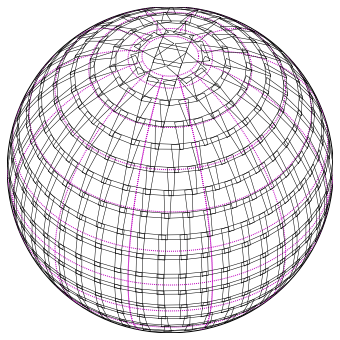

In [87]:
fov = 10. # deg
overlap = 2.2 # deg

fov = np.radians(fov) # radians
overlap = np.radians(overlap) # radians

n = int(np.ceil(np.pi / 2. / (fov - overlap))) * 2 - 1
print(f'Number of declination circles: {n}')

decs = np.linspace(-np.pi/2., np.pi/2., n)

fig = plt.figure(figsize=(6, 6))
m = Basemap(projection='ortho',lon_0=15,lat_0=45,resolution='l')
m.drawparallels(np.arange(-90.,120.,15.),color='m',alpha=0.5)
m.drawmeridians(np.arange(0.,420.,30.),color='m',alpha=0.5)

count_fields = 0

for dec in decs:
    for corners_ra, corners_dec in field_centers_along_dec(fov, overlap=overlap, dec=dec, verbose=1):
        m.plot(np.degrees(corners_ra), np.degrees(corners_dec), color='k', linestyle='-', linewidth=0.5, latlon=True)
        count_fields += 1
    
print(f'Total number of fields: {count_fields}')

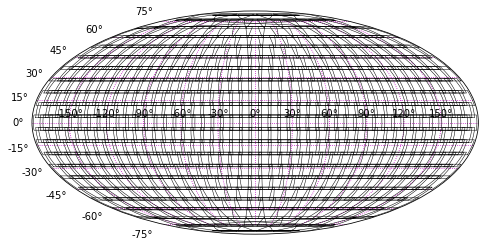

In [88]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(True, color='m', linestyle=':')

for dec in decs:
    for corners_ra, corners_dec in field_centers_along_dec(fov, overlap=overlap, dec=dec, verbose=0):
        ax.plot(corners_ra, corners_dec, color='k', linestyle='-', linewidth=0.5)

### Avoid Galactic plane

We set a Galactic latitude limit, $b_\mathrm{lim}$, and reject all fields that lie entirely within the Galactic plane according to this limit, i.e. we reject fields when *all four* corner points are within $[-b_\mathrm{lim}, b_\mathrm{lim}]$:

Number of declination circles: 23
Total number of fields: 391


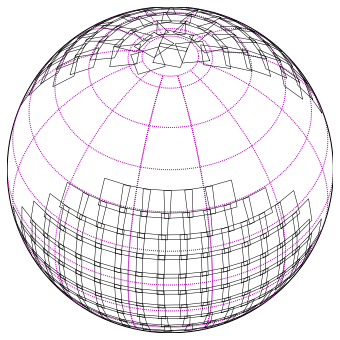

In [89]:
fov = 10. # deg
overlap = 2.2 # deg
gal_lat_lim = 30. #deg

fov = np.radians(fov) # radians
overlap = np.radians(overlap) # radians
gal_lat_lim = np.radians(gal_lat_lim) # radians

n = int(np.ceil(np.pi / 2. / (fov - overlap))) * 2 - 1
print(f'Number of declination circles: {n}')

decs = np.linspace(-np.pi/2., np.pi/2., n)

fig = plt.figure(figsize=(6, 6))
m = Basemap(projection='ortho',lon_0=15,lat_0=45,resolution='l')
m.drawparallels(np.arange(-90.,120.,15.),color='m',alpha=0.5)
m.drawmeridians(np.arange(0.,420.,30.),color='m',alpha=0.5)

count_fields = 0

for dec in decs:
    for corners_ra, corners_dec in field_centers_along_dec(fov, overlap=overlap, dec=dec, verbose=0):
        coord = SkyCoord(corners_ra[:-1], corners_dec[:-1], unit='rad', frame='icrs')
        coord = coord.transform_to('galactic')
        
        if np.all(np.logical_and(
                coord.b.rad < gal_lat_lim, coord.b.rad > -gal_lat_lim)):
            continue
        
        m.plot(np.degrees(corners_ra), np.degrees(corners_dec), color='k', linestyle='-', linewidth=0.5, latlon=True)
        count_fields += 1
    
print(f'Total number of fields: {count_fields}')

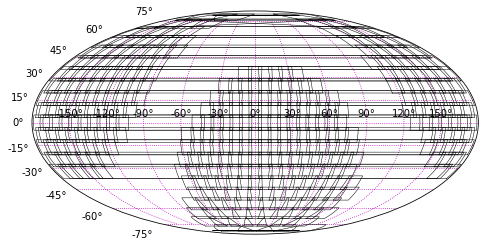

In [90]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(True, color='m', linestyle=':')

for dec in decs:
    for corners_ra, corners_dec in field_centers_along_dec(fov, overlap=overlap, dec=dec, verbose=0):
        coord = SkyCoord(corners_ra[:-1], corners_dec[:-1], unit='rad', frame='icrs')
        coord = coord.transform_to('galactic')
        
        if np.all(np.logical_and(
                coord.b.rad < gal_lat_lim, coord.b.rad > -gal_lat_lim)):
            continue
        
        ax.plot(corners_ra, corners_dec, color='k', linestyle='-', linewidth=0.5)

### `Field` and `SkyFields` class

We gather the above functions in two classes, `Field` and `SkyFields`, implemented in the module `skyfields`.

In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
from skyfields import Field, SkyFields

In [93]:
fov = np.radians(10.)
overlap = np.radians(2.)
tilt = np.radians(0.)
b_lim = np.radians(30.)

fields = SkyFields(fov, overlap, tilt=tilt, b_lim=b_lim)
print(fields)

Creating fields..
Done.                              
SkyFields
Field of view:    10.0000 deg
Overlap            2.0000 deg
Tilt:             +0.0000 deg
Gal. lat. lim:    30.0000 deg
Number of fields: 309


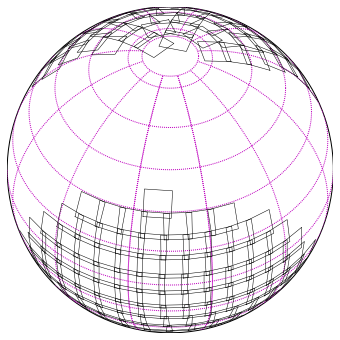

In [94]:
fig = plt.figure(figsize=(6, 6))
m = Basemap(projection='ortho',lon_0=15,lat_0=45,resolution='l')
m.drawparallels(np.arange(-90.,120.,15.),color='m',alpha=0.5)
m.drawmeridians(np.arange(0.,420.,30.),color='m',alpha=0.5)

for field in fields.get_fields():
    corners_ra = field.corners_coord.ra.deg
    corners_ra = np.r_[corners_ra, corners_ra[0]]
    corners_dec = field.corners_coord.dec.deg
    corners_dec = np.r_[corners_dec, corners_dec[0]]
    m.plot(corners_ra, corners_dec, color='k', linestyle='-', linewidth=0.5, latlon=True)

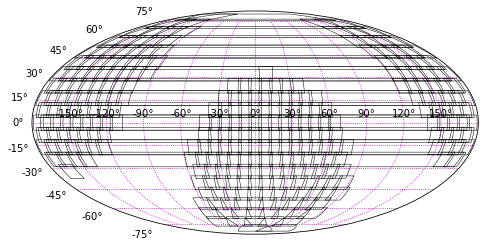

In [95]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(True, color='m', linestyle=':')

for field in fields.get_fields():
    corners_ra = field.corners_coord.ra.rad
    corners_ra = np.r_[corners_ra, corners_ra[0]]
    corners_ra = np.where(corners_ra > np.pi, corners_ra - 2*np.pi, corners_ra)
    corners_dec = field.corners_coord.dec.rad
    corners_dec = np.r_[corners_dec, corners_dec[0]]
    ax.plot(corners_ra, corners_dec, color='k', linestyle='-', linewidth=0.5)

## Pasiphae field grid

<div class="alert alert-block alert-warning">
<b>TBD:</b> Create actual grid. Check for gaps; how much overlap is required to remove gaps? How much tilt is possible without creating gaps? Note that WALOP South has a larger field of view; we need two different grids for the Northern and Southern sky. Overlap region between Northern and Southern instrument for cross-checks?
</div>

In [81]:
fov = 30. # arcmin (Skinakas: 30 arcmin, SAAO: 35 arcmin)
overlap = 2. #arcmin
tilt = 0. # deg
b_lim = 30. # deg

fov = np.radians(fov / 60.)
overlap = np.radians(overlap / 60.)
tilt = np.radians(tilt)
b_lim = np.radians(b_lim)

fields = SkyFields(fov, overlap, tilt=tilt, b_lim=b_lim)
print(fields)

Creating fields..
Dec 385 of 385. 99.7%..SkyFields
Field of view:     0.5000 deg
Overlap            0.0333 deg
Tilt:             +0.0000 deg
Gal. lat. lim:    30.0000 deg
Number of fields: 95153


In [84]:
2 * 3 *95000 / 60 / 8 / 2 / 365

1.6267123287671232

In [91]:
import cartopy.crs as ccrs

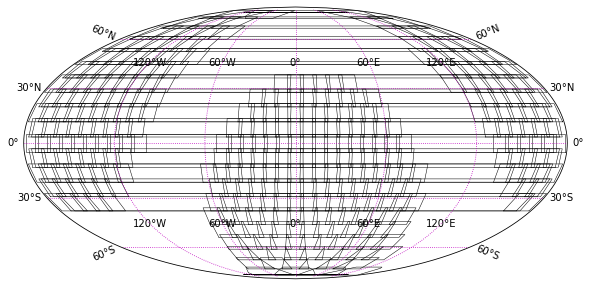

In [120]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
ax.gridlines(draw_labels=True, color='m', linestyle=':')

for field in fields.get_fields():
    corners_ra, corners_dec = field.get_corner_coord(unit='deg', plot=True)
    ax.plot(corners_ra, corners_dec, color='k', linestyle='-', linewidth=0.5, transform=ccrs.PlateCarree())
    #ax.plot([-60, 60, 60, -60], [20, 20, 60, 60], marker='o', color='r', linestyle='-', linewidth=0.5, transform=ccrs.PlateCarree())
ax.set_global()